In [1]:

# This script builds a BLSTM classification model for annotation of a dataset 
# generated from a Convokit Corpus. Most specifically, 'mentalhealth' 
# Subreddit posts and replies.

from convokit import Corpus, download
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import nltk
import sys, os, re, time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from tensorflow import keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix
from numpy import array
from collections import Counter

# NLTK Resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

print('Libraries Loaded')

Libraries Loaded
[nltk_data] Downloading package punkt to /home/buddha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/buddha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/buddha/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:

# Text that invalidates the whole row.
rowInvalidationText = ['', ' ', '[deleted]', '[removed]']
# Additional stopwords
extraStopwords = set(
    ['reddit', 'redditor', 'reddits', 'subreddit', 'subreddits'])

emotionOther = ['love', 'surprise']

# Variables for cleaner() method
stemmer = PorterStemmer() # Stemmer
lem = WordNetLemmatizer()  # Lematizer
prelimStopwords = []
stopWordList = set(stopwords.words('english')).union(
    extraStopwords)  # List of Stopwords
minWordLength = 3  # Minimum word length
maxWordCount = 30  # Maximum words per post


# Simple Report of selected Dataframe
def dataFrameStatus(df: pd.DataFrame):
    print(f'Dataframe shape: {df.shape}')
    for name, _ in df.iteritems():
        print(f'Number of {name}: {df[name].nunique()}')
    print(df.sample(5),'\n')


# Remove invalid posts
def removeInvalidPosts(df: pd.DataFrame, invalidTextList: list) -> pd.DataFrame:
    for invalidText in invalidTextList:
        for name, _ in df.iteritems():
            df = df[df[name] != invalidText]
    df = df.reset_index(drop=True)
    return df

# Partial preprocessing of text.
def rawCleaner(post: str):
    post = re.sub(r'http\S+', '', post)  # Remove URLs
    post = re.sub(r'[^a-zA-Z\s]', '', post)  # Remove Non-letters
    post = post.lower()  # All to Lowercase
    post = word_tokenize(post)  # Tokenize text
    post = [word for word in post if word not in extraStopwords]  # Extra SWs
    post = post[:maxWordCount]  # Limit word count (Post-Token Method)
    post = ' '.join(post)  # Rejoin token into a single string
    sys.stdout.write(f'\r{post[:30]}...')
    return post

# Preprocessing for NLP purposes
def nlpTreatment(entry: str, lemmatizer_over_stemmer: bool = True):
    entry = word_tokenize(entry)  # Tokenize text
    entry = [word for word in entry if word not in stopWordList] # All Stopwords
    if (lemmatizer_over_stemmer):
        entry = [lem.lemmatize(word=word, pos='v') for word in entry]  # Lematize
    else:
        entry = [stemmer.stem(entry) for word in entry] # Stem
    entry = [word for word in entry if len(word) >= minWordLength]  # No short words
    entry = ' '.join(entry)
    sys.stdout.write(f'\r{entry[:30]}...')
    return entry

# Run the RawCleaner on the selected Dataframe
def cleanDF(df: pd.DataFrame, rowInvalidationText: list) -> pd.DataFrame:
    tick = time.time()
    df = removeInvalidPosts(df, rowInvalidationText)
    for name, _ in df.iteritems():
        sys.stdout.write(f'Cleaning raw column "{name}"...\n')
        start = time.time()
        df[name] = df[name].apply(rawCleaner)
        end = time.time()
        sys.stdout.write(
            '\r\rColumn "{}" cleaned ({:.2f}s) ✓\n'.format(name, end - start))
        sys.stdout.flush()
    # removeInvalidPosts() is executed twice because it is possible for the clean()
    # function to return a now invalid value, which would invalidate the row.
    df = removeInvalidPosts(df, rowInvalidationText)
    tock = time.time()
    print('Finished preprocessing ({:.2f}s Total)\n'.format(tock-tick))
    return df

# Splitting function for EDNLP specifically.
def ednlpSplitter(df: pd.DataFrame, headers: list) -> set:
    global e_index
    sys.stdout.write('Cleaning for NLP...\n')
    tick=time.time()
    X = df[headers[0]].apply(nlpTreatment)
    tock = time.time()
    y = df[headers[1]]
    for drop in emotionOther:
        y = y.replace(drop, 'other')
    y, e_index = pd.factorize(y, sort=True)
    sys.stdout.write('\r\rDone ✓. ({:.2f}s)\n'.format(tock - tick))
    sys.stdout.flush()
    return X, y

# Counts the ocurrences of each word in an list of texts.
def counter_word(texts) -> int:
    count = Counter()
    for text in texts.values:
        for word in text.split():
            count[word] += 1
    return count

# Inverse translation from a Padded text sequence back to text (Which ahs been Lematized or Stemmed)
def decodeWordIndex(text, wordIndex):
    reverse_word_index = dict([(value, key) for (key, value) in wordIndex.items()])
    return ' '.join([reverse_word_index.get(i, "?") for i in text])

# Plotting of confussion matrixes or heatmaps.
def plot_confussion_matrix(data, labels, name='output', title='Confussion Matrix', annot=True, fmt='.2f', ylabel='True', xlabel='Predicted'):
    sb.set(color_codes=True)
    plt.figure(1, figsize=(6, 5))
    plt.title = (f'{name} - {title}')
    
    ax = sb.heatmap(data, annot=annot, cmap='BuPu', linecolor='black', fmt=fmt, square=True)
    
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set_title(f'{name} {title}')

    ax.set(ylabel=ylabel, xlabel=xlabel)

    plt.savefig(f'images/{name} {title}.png', bboc_inches='tight', dpi=300)
    plt.show()
    plt.close()

#Plotting of Countbar graphs.
def plot_countbars(data, name):
    sb.set(color_codes=True)
    plt.figure(figsize=(4,4))
    plt.title = (f'{name} Emotion Distribution'.capitalize())

    ax = sb.countplot(data=data, x=f'{name}_emotion', palette='YlGnBu')
    ax.set_xticklabels(e_index)
    ax.set_title(f'{name} Emotion Distribution'.capitalize())
    ax.set(ylabel='Count', xlabel='Emotion')
    
    plt.gcf().subplots_adjust(left=0.25)

    plt.savefig(f'images/{name}_emotion_distrubtion.png', bboc_inches='tight', dpi=300)
    plt.show()
    plt.close()

# Choose the highest values from a set of predicted features.
def predictAndChoose(model, data):
    data = model.predict(data, verbose=1)
    data = data.argmax(axis=1)
    return data

# Return the sequence and padded sequence of a set of features.
def sequencerPadder(data, tokenizer):
    sequence = tokenizer.texts_to_sequences(data) # Features as Sequences
    paddedSequence = pad_sequences(sequence, maxlen=maxWordCount, padding='post', truncating='post') #Features as Padded Sequences
    return sequence, paddedSequence

print("Utility and Preprocessing Functions loaded.")


Utility and Preprocessing Functions loaded.


In [3]:

headers = ['post', 'reply']
# If the dataset already exists, just move on to the next step.
# Otherwise, download and preprocess from convokit corpus
try:
    mhd = pd.read_csv('dataset/mental_health.csv')
    mhd = mhd.reset_index(drop=True)
    print('Mental Health Data found and Loaded\n')
except:
    print('Mental Health Dataset not found at dataset/mental_health.csv. Constructing Dataset. This might take a while...')
    tick = time.time()
    target_subreddit = 'subreddit-mentalhealth'
    corpus = Corpus(download(target_subreddit))
    corpus.print_summary_stats()
    rawDataList = []
    for uID in corpus.get_utterance_ids():
        # Only evaluate for utterances that are, themselves, replies.
        if (corpus.get_utterance(uID).reply_to != None):
            try:
                reply = corpus.get_utterance(uID)
                post = corpus.get_utterance(reply.reply_to)
            except:
                pass
            rawDataList.append([post.text, reply.text])
    mhd = pd.DataFrame(rawDataList, columns=headers)
    mhd = cleanDF(mhd, rowInvalidationText)
    mhd.to_csv('dataset/mental_health.csv', index=False)
    tock = time.time()
    print('Dataset written. ({:.2f}s)\n'.format(tock-tick))

dataFrameStatus(mhd)

Mental Health Data found and Loaded

Dataframe shape: (162647, 2)
Number of post: 108328
Number of reply: 157816
                                                     post  \
145301  i would ask your doctor if you can there might...   
151706  thanks for sharing ive been reading a few sad ...   
51261   okay so this is going to be a very long first ...   
122483  im sorry i cant advise you more clearly on thi...   
23503   well basically i got admitted to the a n e for...   

                                                    reply  
145301  i forgot to mention ive had an mri done that c...  
151706  well it makes me happy that youve taken someth...  
51261   yes i understand this i just want a generic id...  
122483  yes ive done a fair bit of research and we nee...  
23503   whatre you doing physically to help you stay b...   



In [4]:

# Loading EDNLP Data
ec_colnames = ['text', 'emotion']
try:
    ec_train = pd.read_csv('dataset/EDNLP/train.csv', names=ec_colnames, sep=";")
    ec_test = pd.read_csv('dataset/EDNLP/test.csv', names=ec_colnames, sep=";")
    ec_val = pd.read_csv('dataset/EDNLP/val.csv', names=ec_colnames, sep=";")
    print('EDNLP Datasets loaded.')


    ec_train_X, ec_train_y = ednlpSplitter(ec_train, ec_colnames)
    ec_test_X, ec_test_y = ednlpSplitter(ec_test, ec_colnames)
    ec_val_X, ec_val_y = ednlpSplitter(ec_val, ec_colnames)


    # Dictionary that will contain all the split sets of EDNLP
    ednlp = {
        'tr': {'X': ec_train_X, 'y': ec_train_y}, # Training Sets
        'te': {'X': ec_test_X, 'y': ec_test_y}, # Testing Sets
        'va': {'X': ec_val_X, 'y': ec_val_y} #Validation Sets
    }
    print()
    for key in ednlp:
        print('Shape of',key,'\b features:',ednlp[key]['X'].shape)
except:
    print('EDNLP Dataset(s) not found. check for test, val and train CSVs at /dataset/EDNLP')


EDNLP Datasets loaded.
Cleaning for NLP...
Done ✓. (5.56s)
Cleaning for NLP...
Done ✓. (0.51s)
Cleaning for NLP...
Done ✓. (0.52s)

Shape of tr features: (16000,)
Shape of te features: (2000,)
Shape of va features: (2000,)


In [5]:

wordCounter = counter_word(ednlp['tr']['X'])
numWords = len(wordCounter)

tokenizer = Tokenizer(num_words=numWords)
tokenizer.fit_on_texts(ednlp['tr']['X'])
word_index = tokenizer.word_index

for key in ednlp:
    ednlp[key]['Xs'], ednlp[key]['Xp'] = sequencerPadder(ednlp[key]['X'], tokenizer)

print('Sequences and Padded Sequences generated.')


Sequences and Padded Sequences generated.


EDNLP_BLSTM Model loaded.

Model: "EDNLP_BLSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 32)            381888    
_________________________________________________________________
blstm (Bidirectional)        (None, 108)               37584     
_________________________________________________________________
dense (Dense)                (None, 5)                 545       
Total params: 420,017
Trainable params: 420,017
Non-trainable params: 0
_________________________________________________________________
None


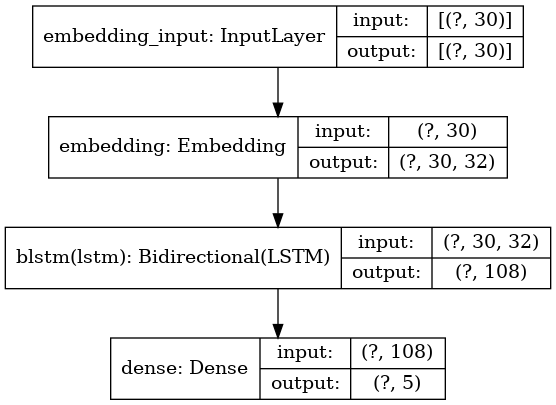

In [6]:

# Attempt to load already-existing model.
# Otherwise, build and train the model.
try:
    model = keras.models.load_model('models/EDNLP_BLSTM')
    print('EDNLP_BLSTM Model loaded.\n')
except:
    print('EDNLP_BLSTM Model not found at models/EDNLP_BLSTM. Building model.')
    # Model Structure
    model = Sequential(name='EDNLP_BLSTM')

    scaleFactor = 8
    embedOutput = 32

    lstmUnits = int(round(
        len(ednlp['tr']['Xp'])
        /
        (scaleFactor * (len(e_index) + embedOutput))
    ))

    print('Target Outputs for unidirectional LSTM Layer:',lstmUnits)

    model.add(Embedding(numWords, embedOutput, input_length=maxWordCount, name='embedding'))
    model.add(Bidirectional(LSTM(lstmUnits, dropout=0.1), name='blstm'))
    model.add(Dense(len(e_index), activation='sigmoid', name='dense'))

    model.get_layer('embedding')

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer = Adam(learning_rate=3e-4),
        metrics=['accuracy'])

    #Model Training
    history =  model.fit(
        ednlp['tr']['Xp'], ednlp['tr']['y'],
        epochs=21,
        use_multiprocessing=True,
        validation_data=(ednlp['va']['Xp'], ednlp['va']['y'])
    )
    # Save model
    print('Saving model...\n')
    model.save('models/EDNLP_BLSTM')

print(model.summary())
plot_model(model, to_file='images/BLSTM_model.png', show_layer_names=True, show_shapes=True)


63/63 [==============================] - 0s 7ms/step
              precision    recall  f1-score   support
anger          0.860902  0.832727  0.846580   275.000
fear           0.780083  0.839286  0.808602   224.000
joy            0.914557  0.831655  0.871138   695.000
other          0.606498  0.746667  0.669323   225.000
sadness        0.902397  0.907057  0.904721   581.000
accuracy       0.845000  0.845000  0.845000     0.845
macro avg      0.812888  0.831478  0.820073  2000.000
weighted avg   0.853929  0.845000  0.847809  2000.000


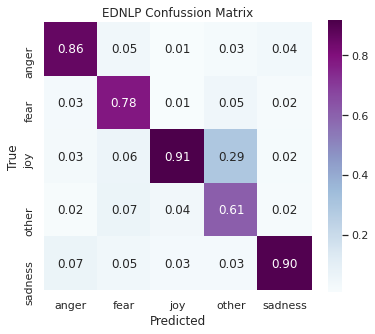

In [7]:

testPrediction = predictAndChoose(model, ednlp['te']['Xp'])

# Accuracy, Presicion, Recall, and F1-Score
report=classification_report(ednlp['te']['y'], testPrediction, target_names=e_index, output_dict=True)
report=pd.DataFrame(report).transpose()
report.to_csv('reports/ednlp.csv', float_format='%.2f')
print(report)

# Confussion Matrix
ednlp_cm=confusion_matrix(ednlp['te']['y'], testPrediction, normalize='pred')
plot_confussion_matrix(ednlp_cm, e_index, name='EDNLP', fmt='.2f')


In [8]:
eHeaders=['post', 'reply', 'post_emotion', 'reply_emotion']

# Attempt to lad already existing EMHD file.
# Otherwise, anotate it from the MHD DataFrame.
try:
    emhd = pd.read_csv('dataset/emotional_mental_health.csv')
    emhd = emhd.reset_index(drop=True)
    print('Emotionally annotated dataset (EMHD) loaded')
#Begin annotating MHD into EMHD
except:
    print('EMHD Not found at dataset/emotional_mental_health.csv. Contructing from MHD.')
    emhd = mhd
    for name, _ in mhd.iteritems():
        sys.stdout.write(f'Annotating column "{name}" with emotion...\n')
        start = time.time()
        treated = mhd[name].apply(nlpTreatment)  # First apply NLP treatment
        _, pSeq = sequencerPadder(treated, tokenizer) # Store padded sequences
        emhd[f'{name}_emotion'] = predictAndChoose(model, pSeq) # Predict and annotate
        end = time.time()
        sys.stdout.write(
            '\r\rColumn "{}" annotated. ({:.2f}s) ✓\n'.format(name, end - start))
        sys.stdout.flush()
    emhd.to_csv('dataset/emotional_mental_health.csv', index=False)

dataFrameStatus(emhd)


Emotionally annotated dataset (EMHD) loaded
Dataframe shape: (162647, 4)
Number of post: 108328
Number of reply: 157816
Number of post_emotion: 5
Number of reply_emotion: 5
                                                    post  \
38471  my girlfriend has been struggling with depress...   
47689  how is this a surprise to anyone i thought thi...   
5506   i work in an outpatient ward in a psychiatric ...   
6993   over the past or years our family has fallen o...   
60865  hello im not really sure what i want to get ou...   

                                                   reply  post_emotion  \
38471  if she is against taking medication and gets d...             2   
47689  yeah everyone knows plus your doctors advice w...             3   
5506   ive been to inpatient and outpatient therapy i...             3   
6993   since you clearly have legitimate grievances a...             3   
60865  gt what can i do to get better memoryltgtemoti...             2   

       reply_emotion 

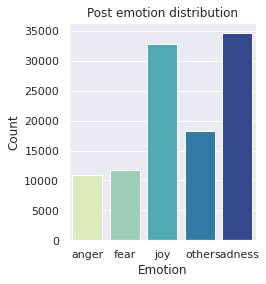

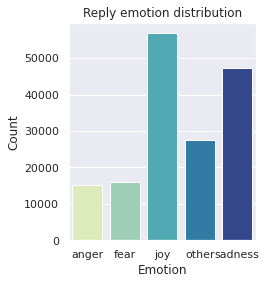

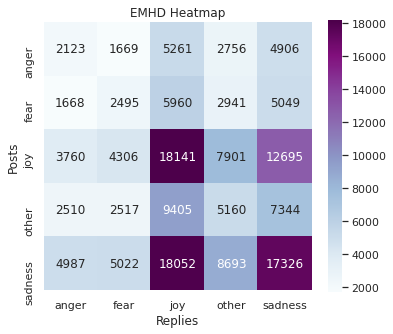

In [9]:

#Countplots
unique_posts_emhd = emhd.drop_duplicates(['post'])
plot_countbars(unique_posts_emhd,'post')
plot_countbars(emhd, 'reply')

#Heatmap
emhd_cm = confusion_matrix(emhd['post_emotion'], emhd['reply_emotion'], normalize=None)
plot_confussion_matrix(emhd_cm, e_index, name='EMHD', title='Heatmap', ylabel='Posts', xlabel='Replies', fmt='d')


In [10]:
print(':)')

:)
